<a href="https://colab.research.google.com/github/SilverQ/dl_study/blob/master/Udacity_ud187/lab06_Transfer_Learning_with_Tensorflow_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install "tf-nightly-gpu==1.14.1-dev20190409"
!pip install "tensorflow_hub==0.4.0"

     |████████████████████████████████| 392.7MB 48kB/s 
     |████████████████████████████████| 3.2MB 27.2MB/s 
     |████████████████████████████████| 501kB 41.6MB/s 
     |████████████████████████████████| 81kB 3.1MB/s 
  Found existing installation: tensorflow-hub 0.5.0
    Uninstalling tensorflow-hub-0.5.0:
      Successfully uninstalled tensorflow-hub-0.5.0


In [0]:
from __future__ import absolute_import, division, print_function
import matplotlib.pylab as plt
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.enable_eager_execution()
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

### Part1 : Use a Tensorflow Hub Mobilenet for prediction
* taking a trained MobileNet v2 model, loading it into Keras

In [0]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

#### Running on a single image

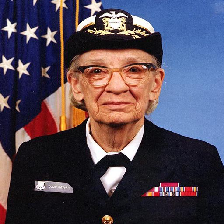

In [0]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [0]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [0]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [0]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

#### Decode the prediction

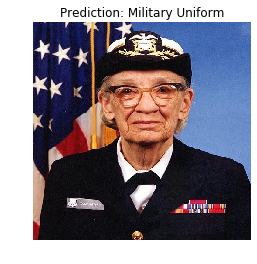

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title('Prediction: ' + predicted_class_name.title())

### Part2. Using a Tensorflow Hub models for the Cats vs Dogs dataset

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


W0725 01:03:17.121021 140684920375168 cats_vs_dogs.py:117] 1738 images were corrupted and were skipped


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [0]:
for i, example_image in enumerate(train_examples.take(3)):
  print('Image {} shape {}'.format(i+1, example_image[0].shape))

Image 1 shape (500, 343, 3)
Image 2 shape (375, 500, 3)
Image 3 shape (375, 500, 3)


In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Border collie', 'tabby', 'Chihuahua', 'flat-coated retriever',
       'tiger cat', 'Persian cat', 'tabby', 'Norwegian elkhound',
       'Rottweiler', 'Egyptian cat', 'lynx', 'tiger cat',
       'Chesapeake Bay retriever', 'golden retriever', 'tabby', 'tabby',
       'Egyptian cat', 'Egyptian cat', 'tabby', 'Lhasa', 'diaper',
       'Egyptian cat', 'tiger cat', 'miniature schnauzer', 'tabby',
       'Siamese cat', 'beagle', 'basenji', 'malinois', 'silky terrier',
       'Egyptian cat', 'Norfolk terrier'], dtype='<U30')

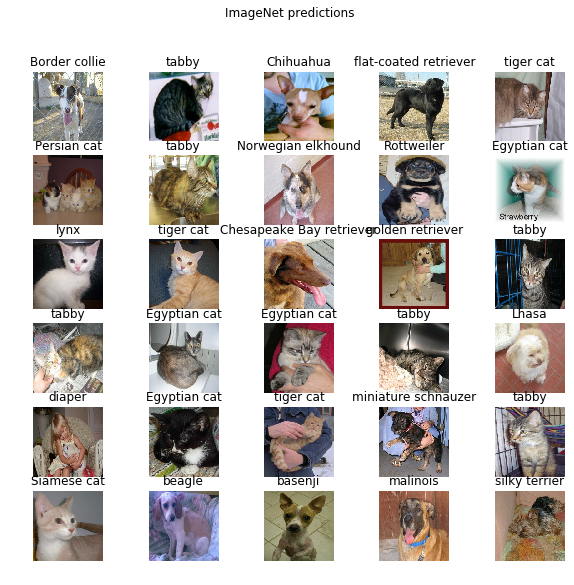

In [0]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle('ImageNet predictions')

### Part3. Simple Transfer learning

In [0]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'
feature_extractor = hub.KerasLayer(URL,
                                  input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [0]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor.trainable = False

In [0]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                   epochs=EPOCHS,
                   validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 72s 124ms/step - loss: 0.0512 - acc: 0.9834 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
582/582 [==============================] - 70s 121ms/step - loss: 0.0299 - acc: 0.9903 - val_loss: 0.0309 - val_acc: 0.9877
Epoch 3/6
582/582 [==============================] - 70s 121ms/step - loss: 0.0249 - acc: 0.9926 - val_loss: 0.0307 - val_acc: 0.9884
Epoch 4/6
582/582 [==============================] - 70s 121ms/step - loss: 0.0216 - acc: 0.9937 - val_loss: 0.0312 - val_acc: 0.9873
Epoch 5/6
582/582 [==============================] - 70s 121ms/step - loss: 0.0192 - acc: 0.9945 - val_loss: 0.0321 - val_acc: 0.9877
Epoch 6/6
582/582 [==============================] - 70s 121ms/step - loss: 0.0171 - acc: 0.9955 - val_loss: 0.0332 - val_acc: 0.9875


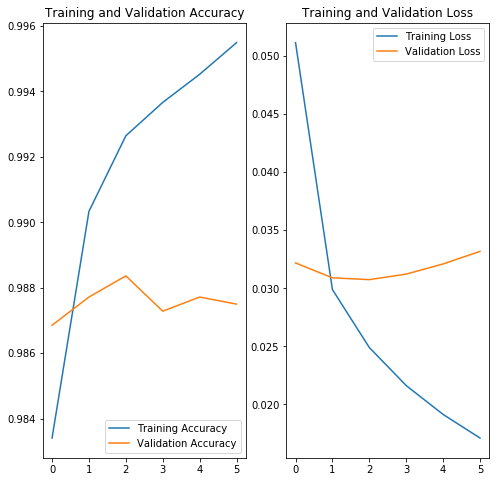

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog',
       'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat',
       'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog',
       'dog', 'dog', 'dog', 'cat', 'dog'], dtype='<U3')

In [0]:
print('Labels: ', label_batch)
print('Predicted labels: ', predicted_ids)

Labels:  [1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1]
Predicted labels:  [1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1]


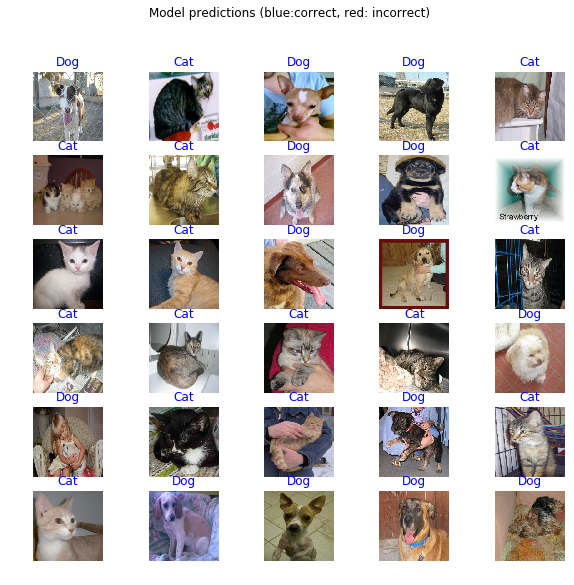

In [0]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue:correct, red: incorrect)")